In [32]:
from src.visualise import settings
from src.data.paths import project_dir

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from lmfit.models import StepModel, LinearModel

from pathlib import Path

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Data

In [33]:
base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'
base_path.exists()

True

# Efficiency data

In [34]:
df = pd.read_hdf(base_path / '2024-04-22_PB_with_EBT_4Gy' / 'data' / 'interim' / 'data.h5', key='df')
df

,det_no,mean_signal,std_signal,radiation,circle_no
17000,1,80.038462,25.063480,Co60,0
17001,1,81.993569,26.837608,Co60,1
17002,1,81.284810,26.681096,Co60,2
17003,1,78.117089,24.694889,Co60,3
17004,1,83.433544,26.589924,Co60,4
...,...,...,...,...,...
16995,17,150.144231,37.069344,proton,995
16996,17,193.375394,36.173536,proton,996
16997,17,168.557692,34.193031,proton,997
16998,17,163.426752,36.822557,proton,998


In [35]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean        std
radiation det_no                       
Co60      1        81.205454   1.873170
          2        81.611696   1.234760
          3        82.490079   2.229555
          4        83.726520   2.417854
          5        82.164689   2.542740
          6        78.619051   2.257834
          7        79.692557   2.702632
          8        73.068703   9.998371
          9        82.579418   1.607045
          10       76.107739   1.894623
          11       76.536956   1.950267
          12       76.747347   1.940899
          13       78.274351   2.905702
          14       77.551568   2.444968
          15       74.437340   2.189473
          16       78.748348   2.921456
          17       78.599773   1.785468
proton    1        72.276431   2.025129
          2        71.770233   1.906493
          3        74.265594   4.210277
          4        80.166608   4.323314
          5        66.187989   9.028334
          6        92.690080   7.359619
          7        96.701272   8.018962
          8       105.813032  11.420628
          9       115.989550  16.063452
          10      116.911694  14.889479
          11      121.934511  11.044092
          12      131.316633  16.123715
          13      139.529757  14.929736
          14      148.368301  17.698476
          15      148.287345  20.582696
          16      154.245708  27.273083
          17      174.422883  24.544723

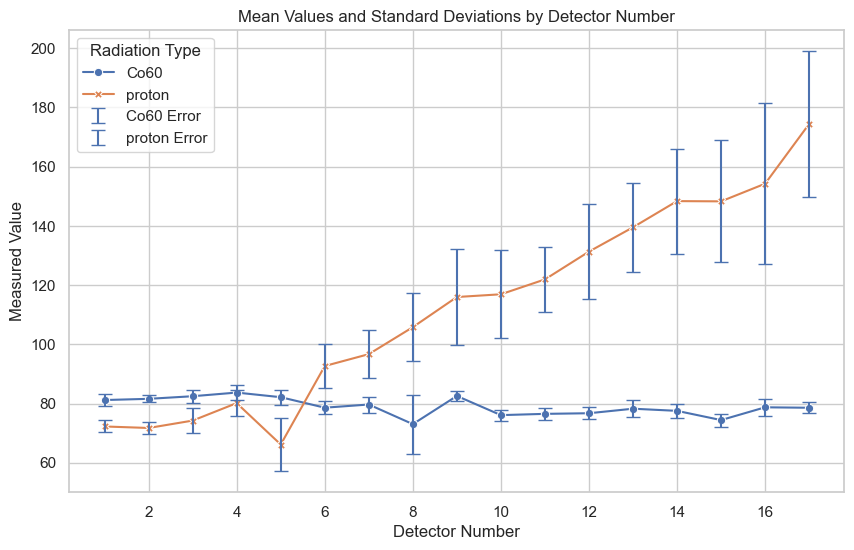

In [36]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

# Bragg peak data from dosimetry and MC

In [37]:
plots_path = base_path / '2024-04-22_PB_with_EBT_4Gy' / 'article-plots.h5'
df_bp_exp = pd.read_hdf(plots_path, key='bp_exp')
df_bp_mc = pd.read_hdf(plots_path, key='bp_mc')

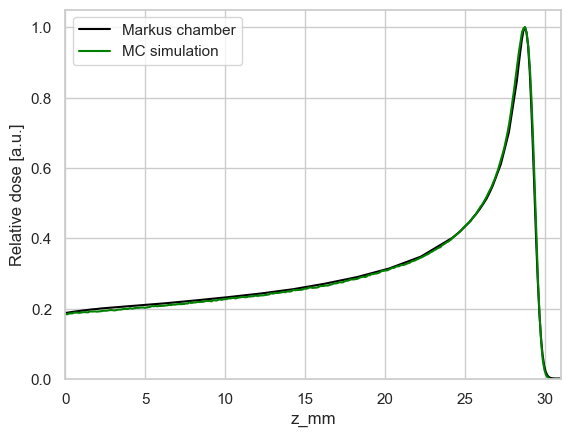

In [38]:
fig, ax_up = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax_up, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax_up, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax_up.set_ylim(0,1.05)
ax_up.set_xlim(0, 31)
ax_up.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [40]:
xls_path = base_path / '2024-04-22_PB_with_EBT_4Gy' / 'fantom.xlsx'
df_pos = pd.read_excel(xls_path, 
    skiprows=6, 
    nrows=31, 
    usecols="A,C,D,E",
    names=["det_no", "name", "det_thick", "WER"]
    )
# add new column det_start which is sum of WER for all indexes lower than current
df_pos['det_end'] = df_pos.WER.cumsum()
df_pos['det_begin'] = df_pos.det_end - df_pos.WER
df_pos = df_pos[df_pos.name == 'folia MBO']
df_pos.drop("name", axis=1, inplace=True)
df_pos['det_mid'] = (df_pos.det_begin + df_pos.det_end) / 2
df_pos.det_no = df_pos.det_no.astype(int)
df_pos

,det_no,det_thick,WER,det_end,det_begin,det_mid
0,1,0.42,0.4410,0.4410,0.0000,0.22050
3,2,0.41,0.4305,3.4271,2.9966,3.21185
6,3,0.43,0.4515,6.4342,5.9827,6.20845
9,4,0.44,0.4620,9.4404,8.9784,9.20940
12,5,0.44,0.4620,12.4466,11.9846,12.21560
15,6,0.42,0.4410,15.4204,14.9794,15.19990
18,7,0.44,0.4620,18.3924,17.9304,18.16140
21,8,0.43,0.4515,21.3881,20.9366,21.16235
24,9,0.41,0.4305,24.3514,23.9209,24.13615
25,10,0.43,0.4515,24.8029,24.3514,24.57715


In [41]:
# join df_reset with df_pos on det_no
df_reset_pos = df2_reset.join(df_pos.set_index('det_no'), on='det_no')
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid
0,Co60,1,81.205454,1.873170,0.42,0.4410,0.4410,0.0000,0.22050
1,Co60,2,81.611696,1.234760,0.41,0.4305,3.4271,2.9966,3.21185
2,Co60,3,82.490079,2.229555,0.43,0.4515,6.4342,5.9827,6.20845
3,Co60,4,83.726520,2.417854,0.44,0.4620,9.4404,8.9784,9.20940
4,Co60,5,82.164689,2.542740,0.44,0.4620,12.4466,11.9846,12.21560
5,Co60,6,78.619051,2.257834,0.42,0.4410,15.4204,14.9794,15.19990
6,Co60,7,79.692557,2.702632,0.44,0.4620,18.3924,17.9304,18.16140
7,Co60,8,73.068703,9.998371,0.43,0.4515,21.3881,20.9366,21.16235
8,Co60,9,82.579418,1.607045,0.41,0.4305,24.3514,23.9209,24.13615
9,Co60,10,76.107739,1.894623,0.43,0.4515,24.8029,24.3514,24.57715


(0.0, 30.0)

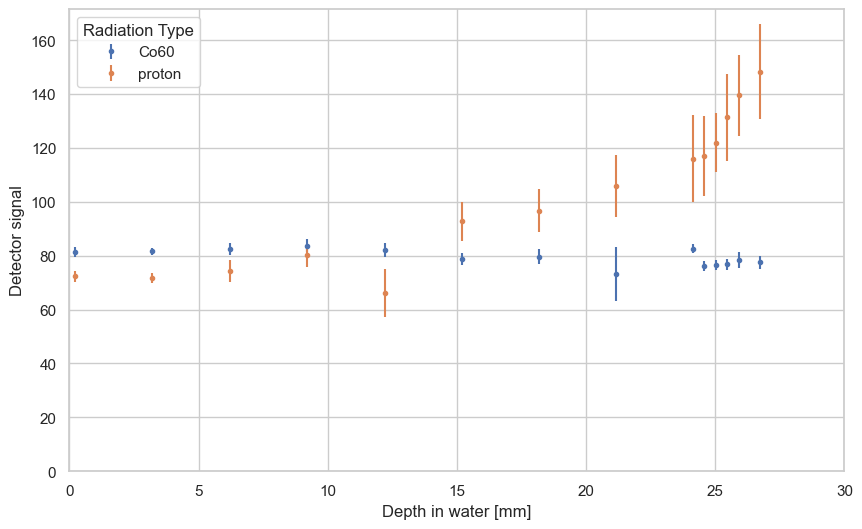

In [42]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean'], yerr=subset['std'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Detector signal')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

# Dose per detector

In [43]:
df_bp_mc

,zlower_cm,zupper_cm,dose,r.err,z_mm,dose_Gy
26,0.00,0.01,0.184743,0.0033,0.05,20.000000
27,0.01,0.02,0.184782,0.0034,0.15,20.004237
28,0.02,0.03,0.187052,0.0049,0.25,20.249965
29,0.03,0.04,0.186947,0.0041,0.35,20.238667
30,0.04,0.05,0.187195,0.0049,0.45,20.265499
...,...,...,...,...,...,...
421,3.95,3.96,0.000006,0.4542,39.55,0.000676
422,3.96,3.97,0.000016,0.5727,39.65,0.001760
423,3.97,3.98,0.000025,0.7804,39.75,0.002744
424,3.98,3.99,0.000028,0.7334,39.85,0.003082


In [44]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose

f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [45]:
df_bp_mc.iloc[0].dose

0.1847426230791307

In [46]:
# for such rows of df_reset_pos where radiation is 'proton' calculate 'dose' as f(df_reset_pos.det_mid)
entrance_dose_protons_Gy = 4
dose_Co60 = 4
df_reset_pos.loc[df_reset_pos.radiation == 'proton', 'dose'] = f(df_reset_pos[df_reset_pos.radiation == 'proton'].det_mid) / df_bp_mc.iloc[0].dose * entrance_dose_protons_Gy
df_reset_pos.loc[df_reset_pos.radiation == 'Co60', 'dose'] = dose_Co60

In [47]:
df_reset_pos['mean_signal_per_Gy'] = df_reset_pos['mean'] / df_reset_pos['dose']
df_reset_pos['std_signal_per_Gy'] = df_reset_pos['std'] / df_reset_pos['dose']
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid,dose,mean_signal_per_Gy,std_signal_per_Gy
0,Co60,1,81.205454,1.873170,0.42,0.4410,0.4410,0.0000,0.22050,4.000000,20.301364,0.468292
1,Co60,2,81.611696,1.234760,0.41,0.4305,3.4271,2.9966,3.21185,4.000000,20.402924,0.308690
2,Co60,3,82.490079,2.229555,0.43,0.4515,6.4342,5.9827,6.20845,4.000000,20.622520,0.557389
3,Co60,4,83.726520,2.417854,0.44,0.4620,9.4404,8.9784,9.20940,4.000000,20.931630,0.604463
4,Co60,5,82.164689,2.542740,0.44,0.4620,12.4466,11.9846,12.21560,4.000000,20.541172,0.635685
5,Co60,6,78.619051,2.257834,0.42,0.4410,15.4204,14.9794,15.19990,4.000000,19.654763,0.564458
6,Co60,7,79.692557,2.702632,0.44,0.4620,18.3924,17.9304,18.16140,4.000000,19.923139,0.675658
7,Co60,8,73.068703,9.998371,0.43,0.4515,21.3881,20.9366,21.16235,4.000000,18.267176,2.499593
8,Co60,9,82.579418,1.607045,0.41,0.4305,24.3514,23.9209,24.13615,4.000000,20.644855,0.401761
9,Co60,10,76.107739,1.894623,0.43,0.4515,24.8029,24.3514,24.57715,4.000000,19.026935,0.473656


(0.0, 30.0)

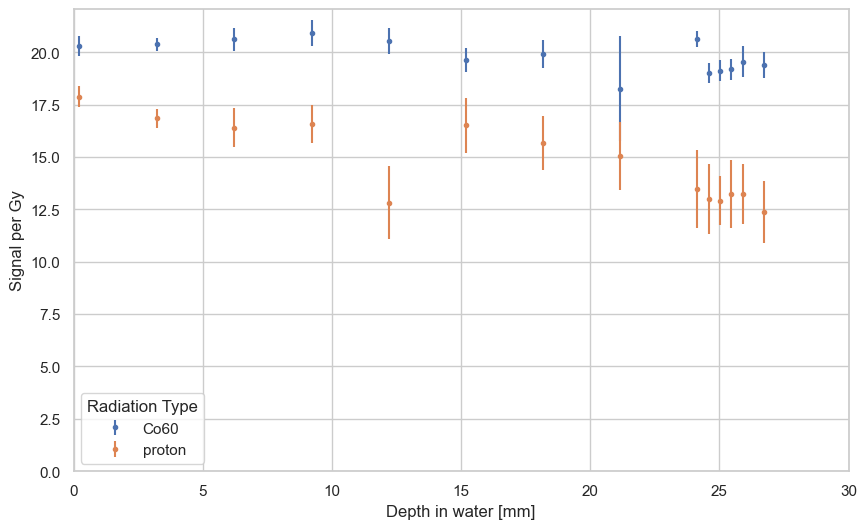

In [48]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean_signal_per_Gy'], yerr=subset['std_signal_per_Gy'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

In [49]:
co60_data = df_reset_pos.loc[df_reset_pos.radiation == 'Co60']
proton_data = df_reset_pos.loc[df_reset_pos.radiation == 'proton']
all_data = co60_data.merge(proton_data, on='det_no', suffixes=['_Co60', '_proton'])
all_data['mean_efficiency'] = all_data['mean_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
numerator_relative_std = all_data['std_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
denominator_term = all_data['mean_signal_per_Gy_proton'] * all_data['std_signal_per_Gy_Co60'] / (all_data['mean_signal_per_Gy_Co60']**2)
all_data['std_efficiency'] = numerator_relative_std + denominator_term

In [50]:
all_data = all_data[all_data.det_no < 14]

(0.0, 30.0)

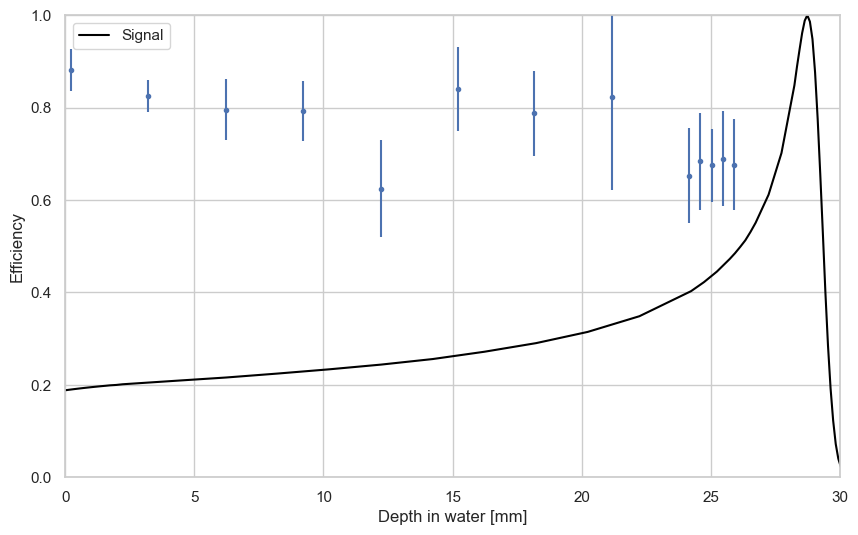

In [51]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')
ax.errorbar(all_data['det_mid_proton'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='.', label=f'efficiency')
df_bp_exp.plot(ax=ax, x='Depth', y='Signal', color='black', style='-')
ax.set_xlabel('Depth in water [mm]')
ax.set_ylabel('Efficiency')
ax.set_ylim(0,1)
ax.set_xlim(0,30)

# Kinetic energy

In [52]:
df_bp_kin_en = pd.read_hdf(plots_path, key='bp_kin_en')

In [53]:
from scipy.interpolate import UnivariateSpline
bp_kin_en_spl = UnivariateSpline(df_bp_kin_en.z_mm.values, df_bp_kin_en.ef_q50.values)

In [54]:
all_data['ekin_MeV'] = bp_kin_en_spl(all_data['det_mid_proton'])

In [55]:
all_data

,radiation_Co60,det_no,mean_Co60,std_Co60,det_thick_Co60,WER_Co60,det_end_Co60,det_begin_Co60,det_mid_Co60,dose_Co60,...,WER_proton,det_end_proton,det_begin_proton,det_mid_proton,dose_proton,mean_signal_per_Gy_proton,std_signal_per_Gy_proton,mean_efficiency,std_efficiency,ekin_MeV
0,Co60,1,81.205454,1.873170,0.42,0.4410,0.4410,0.0000,0.22050,4.0,...,0.4410,0.4410,0.0000,0.22050,4.038866,17.895231,0.501410,0.881479,0.045031,58.261703
1,Co60,2,81.611696,1.234760,0.41,0.4305,3.4271,2.9966,3.21185,4.0,...,0.4305,3.4271,2.9966,3.21185,4.259571,16.849171,0.447579,0.825821,0.034431,53.830507
2,Co60,3,82.490079,2.229555,0.43,0.4515,6.4342,5.9827,6.20845,4.0,...,0.4515,6.4342,5.9827,6.20845,4.525915,16.408970,0.930260,0.795682,0.066615,50.041998
3,Co60,4,83.726520,2.417854,0.44,0.4620,9.4404,8.9784,9.20940,4.0,...,0.4620,9.4404,8.9784,9.20940,4.833381,16.586030,0.894470,0.792391,0.065616,46.548917
4,Co60,5,82.164689,2.542740,0.44,0.4620,12.4466,11.9846,12.21560,4.0,...,0.4620,12.4466,11.9846,12.21560,5.159545,12.828261,1.749831,0.624515,0.104513,42.998374
5,Co60,6,78.619051,2.257834,0.42,0.4410,15.4204,14.9794,15.19990,4.0,...,0.4410,15.4204,14.9794,15.19990,5.613426,16.512211,1.311074,0.840112,0.090832,39.073597
6,Co60,7,79.692557,2.702632,0.44,0.4620,18.3924,17.9304,18.16140,4.0,...,0.4620,18.3924,17.9304,18.16140,6.164426,15.686988,1.300845,0.787375,0.091996,34.442226
7,Co60,8,73.068703,9.998371,0.43,0.4515,21.3881,20.9366,21.16235,4.0,...,0.4515,21.3881,20.9366,21.16235,7.032643,15.045984,1.623945,0.823662,0.201606,28.652848
8,Co60,9,82.579418,1.607045,0.41,0.4305,24.3514,23.9209,24.13615,4.0,...,0.4305,24.3514,23.9209,24.13615,8.613210,13.466472,1.864979,0.652292,0.103030,21.482226
9,Co60,10,76.107739,1.894623,0.43,0.4515,24.8029,24.3514,24.57715,4.0,...,0.4515,24.8029,24.3514,24.57715,8.991842,13.001973,1.655887,0.683346,0.104040,20.276356


(0.0, 60.0)

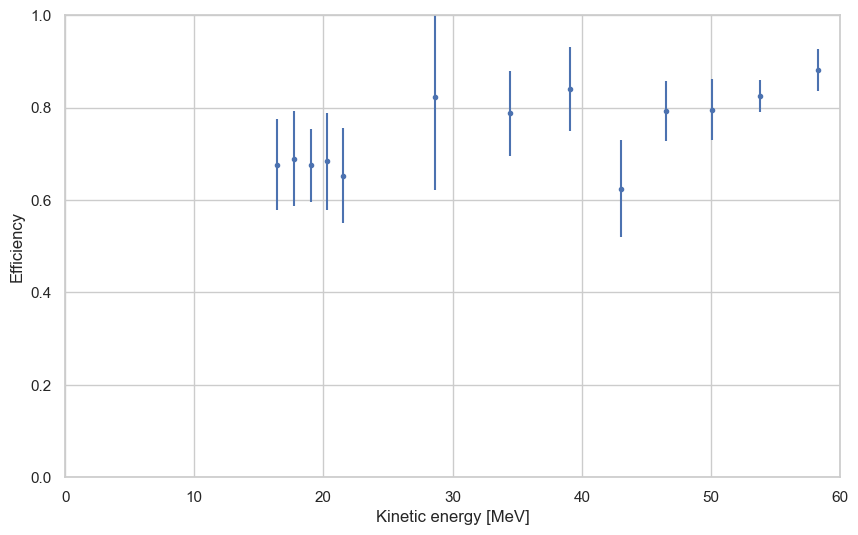

In [56]:
plt.figure(figsize=(10, 6))
plt.errorbar(all_data['ekin_MeV'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='.', label=f'efficiency')
plt.xlabel('Kinetic energy [MeV]')
plt.ylabel('Efficiency')
plt.ylim(0,1)
plt.xlim(0,60)

In [57]:

x_values_for_fit = all_data['ekin_MeV']
y_values_for_fit = all_data['mean_efficiency']
#mod = StepModel(form='logistic')
step_mod = StepModel(form='atan')
#lin_mod = LinearModel()
pars = step_mod.guess(y_values_for_fit, x=x_values_for_fit)
#pars += lin_mod.guess(y_values_for_fit, x=x_values_for_fit)
#pars['intercept'].min = 1e-5
#pars['amplitude'].min = 1e-5
#mod = step_mod + lin_mod
mod = step_mod
out = mod.fit(y_values_for_fit, pars, x=x_values_for_fit)
x_for_plotting = np.linspace(0,60,num=100)
y_for_plotting = out.eval(x=x_for_plotting)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(step, form='atan')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 173
    # data points      = 13
    # variables        = 3
    chi-square         = 0.04548475
    reduced chi-square = 0.00454847
    Akaike info crit   = -67.5192585
    Bayesian info crit = -65.8244104
    R-squared          = 0.47287103
[[Variables]]
    amplitude:  0.98927403 +/- 0.46669816 (47.18%) (init = 0.2569647)
    center:    -6.17204208 +/- 23.4376261 (379.74%) (init = 37.32975)
    sigma:      36.1560486 +/- 107.417710 (297.09%) (init = 5.980558)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma)  = +0.9916
    C(center, sigma)     = -0.8966
    C(amplitude, center) = -0.8370


(0.0, 1.0)

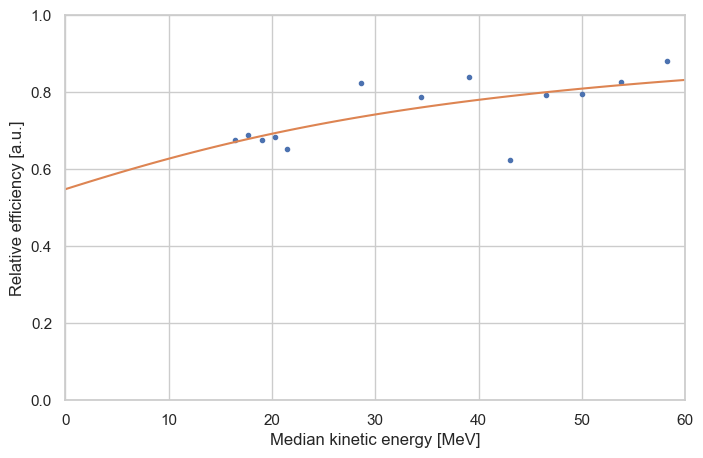

In [58]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(all_data['ekin_MeV'], all_data['mean_efficiency'], marker=".", linestyle="")
ax.plot(x_for_plotting, y_for_plotting)
ax.set_xlabel('Median kinetic energy [MeV]')
ax.set_ylabel('Relative efficiency [a.u.]')
ax.set_xlim(0,60)
ax.grid(True)
ax.set_ylim(0,1)

In [59]:
from lmfit.model import save_modelresult, save_model
base_output_path = base_path / '2024-04-22_PB_with_EBT_4Gy' / 'data' / 'interim'
model_output_path = base_output_path / 'PB_4Gy'
#print(model_output_path)
save_model(mod, model_output_path / 'model.sav')
save_modelresult(out, model_output_path / 'model_result.sav')

In [60]:
all_data.columns

Index(['radiation_Co60', 'det_no', 'mean_Co60', 'std_Co60', 'det_thick_Co60',
       'WER_Co60', 'det_end_Co60', 'det_begin_Co60', 'det_mid_Co60',
       'dose_Co60', 'mean_signal_per_Gy_Co60', 'std_signal_per_Gy_Co60',
       'radiation_proton', 'mean_proton', 'std_proton', 'det_thick_proton',
       'WER_proton', 'det_end_proton', 'det_begin_proton', 'det_mid_proton',
       'dose_proton', 'mean_signal_per_Gy_proton', 'std_signal_per_Gy_proton',
       'mean_efficiency', 'std_efficiency', 'ekin_MeV'],
      dtype='object')

In [61]:
all_data[['det_no', 'ekin_MeV', 'dose_proton', 'det_mid_proton', 'mean_efficiency', 'std_efficiency', 'mean_signal_per_Gy_Co60']].to_hdf(model_output_path / 'detectors_data.h5', key='df')